In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import pytensor.tensor as pt
import seaborn as sns
import pymc as pm
import multiprocessing
import arviz as az
import warnings
import sys

sys.path.append(os.path.abspath(os.path.join("../")))

from src.evaluate import ams_score, report_metrics

# --- Reproducibility setup ---
SEED = 1

np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
pm.set_data = getattr(pm, "set_data", lambda *args, **kwargs: None)

# --- Warning filters ---
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Load data

In [2]:
# Load preprocessed data
train_preprocess = pd.read_csv("../data/processed/train_preprocess.csv")
test_preprocess = pd.read_csv("../data/processed/test_preprocess.csv")

# Separate features and labels
X_train = train_preprocess.drop(["Weight", "Label"], axis=1)
X_test = test_preprocess.drop(["Weight", "Label"], axis=1)
y_train = train_preprocess["Label"]
y_test = test_preprocess["Label"]

# Extract weights
weights_train = train_preprocess["Weight"]
weights_test = test_preprocess["Weight"]

print("Data loaded successfully:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

Data loaded successfully:
X_train shape: (589448, 17)
X_test shape: (104188, 17)


# Bayesian logistic regression model


In [3]:
# If dataset is huge, MCMC may be slow. We'll sample a reasonable subset, preserving class balance.
max_train_samples = 10000
feature_names = list(X_train.columns)

if X_train.shape[0] > max_train_samples:
    # stratified sampling
    train_df = X_train.copy()
    train_df["y"] = y_train
    train_small = train_df.groupby("y").sample(n=int(max_train_samples / 2), random_state=42)
    X_bayes = train_small[feature_names].values
    y_bayes = train_small["y"].values
    print("Using subsample for MCMC:", X_bayes.shape)
else:
    X_bayes = X_train.values
    y_bayes = y_train.values
    print("Using full training set for MCMC:", X_bayes.shape)

Using subsample for MCMC: (10000, 17)


In [4]:
"""
Train Bayesian LogReg. Computationally expensive. Skip this chunck to just load the model saved in models/
"""
n_samples, n_features = X_bayes.shape

with pm.Model() as bayesian_logistic_model:
    # --- Priors ---
    # Define priors based on Gelman et al. (2008) 
    # Intercept: Cauchy(0, 10) or StudentT(nu=1, mu=0, sigma=10)
    intercept = pm.StudentT('intercept', nu=1, mu=0, sigma=10)
    
    # Coefficients: Cauchy(0, 2.5) or StudentT(nu=1, mu=0, sigma=2.5)
    betas = pm.StudentT('betas', nu=1, mu=0, sigma=2.5, 
                       shape=n_features, dims="features")
    
    # --- Linear Predictor ---
    # The linear combination (log-odds, or eta)
    eta = intercept + pt.dot(X_bayes, betas)
    
    # --- Likelihood ---
    # We model the observed data y_train as a Bernoulli trial.
    # We use 'logit_p=eta' which is the numerically stable
    # way to specify a Bernoulli likelihood with a logit link.
    y_obs = pm.Bernoulli('y_obs', logit_p=eta, observed=y_bayes)
    
    # --- Inference (Sampling) ---
    # Use NUTS sampler to draw from the posterior
    print("Starting MCMC sampling...")
    trace = pm.sample(2000, tune=1000, chains=4, cores=4, 
                      target_accept=0.9,
                      idata_kwargs={'log_likelihood': True})
    print("Sampling complete.")
# --- Model Diagnostics ---
# R-hat should be < 1.01 for all parameters to indicate convergence
summary = az.summary(trace, var_names=['intercept', 'betas'])
print(summary)

# Save the trace for later analysis
trace.to_netcdf("../models/bayesian_logreg_trace.nc")

Starting MCMC sampling...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, betas]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 137 seconds.


Sampling complete.
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept -0.153  0.023  -0.195   -0.107      0.000    0.000    9449.0   
betas[0]  -0.678  0.053  -0.778   -0.579      0.001    0.001    5269.0   
betas[1]  -0.633  0.031  -0.692   -0.575      0.000    0.000    7417.0   
betas[2]   0.567  0.086   0.410    0.732      0.001    0.001    5165.0   
betas[3]   1.015  0.058   0.902    1.121      0.001    0.001    5200.0   
betas[4]  -0.251  0.027  -0.307   -0.204      0.000    0.000    8898.0   
betas[5]  -0.541  0.069  -0.666   -0.409      0.001    0.001    5571.0   
betas[6]  -0.710  0.065  -0.826   -0.582      0.001    0.001    4678.0   
betas[7]   0.317  0.030   0.260    0.372      0.000    0.000    7848.0   
betas[8]   0.482  0.053   0.381    0.580      0.001    0.001    5610.0   
betas[9]  -0.028  0.029  -0.081    0.026      0.000    0.000    6812.0   
betas[10]  0.019  0.024  -0.024    0.065      0.000    0.000    9755.0   
betas[11]  0.778  0

'../models/bayesian_logreg_trace.nc'

In [5]:
# Load the model
n_samples, n_features = X_bayes.shape
trace = az.from_netcdf("../models/bayesian_logreg_trace.nc")

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.153,0.023,-0.198,-0.107,0.000,0.000,9449.0,6288.0,1.0
betas[0],-0.678,0.053,-0.780,-0.573,0.001,0.001,5269.0,5501.0,1.0
betas[1],-0.633,0.031,-0.692,-0.571,0.000,0.000,7417.0,6251.0,1.0
betas[2],0.567,0.086,0.404,0.739,0.001,0.001,5165.0,5588.0,1.0
betas[3],1.015,0.058,0.893,1.122,0.001,0.001,5200.0,5545.0,1.0
betas[4],-0.251,0.027,-0.307,-0.199,0.000,0.000,8898.0,6304.0,1.0
betas[5],-0.541,0.069,-0.672,-0.404,0.001,0.001,5571.0,5866.0,1.0
betas[6],-0.710,0.065,-0.837,-0.581,0.001,0.001,4678.0,5385.0,1.0
betas[7],0.317,0.030,0.256,0.374,0.000,0.000,7848.0,5804.0,1.0
betas[8],0.482,0.053,0.381,0.588,0.001,0.001,5610.0,6105.0,1.0


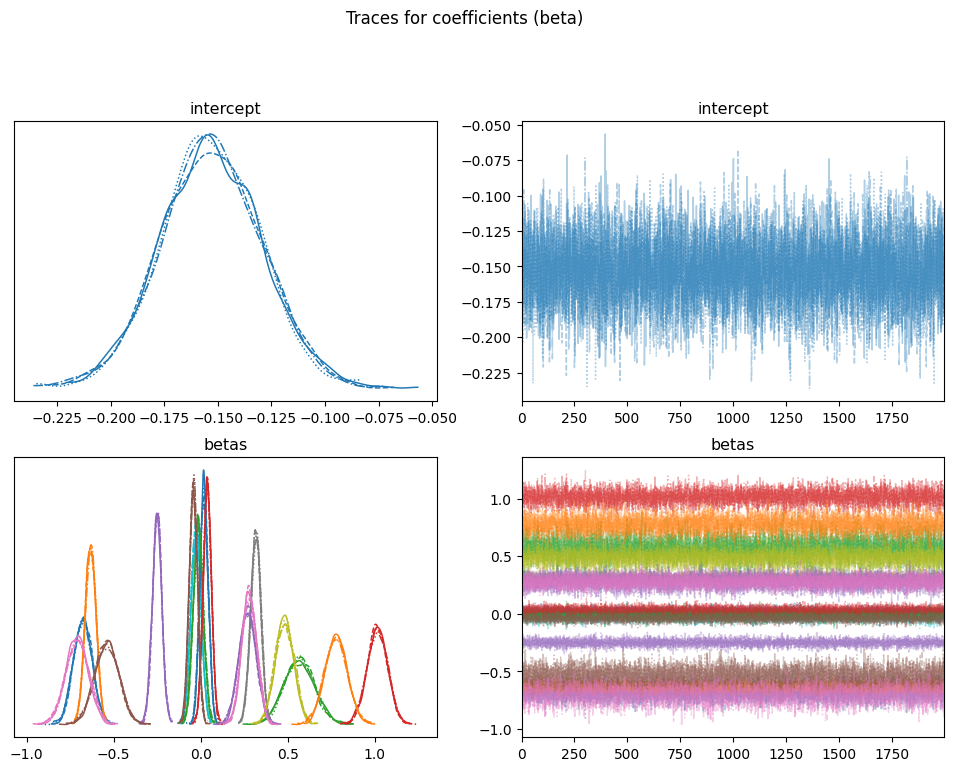

In [6]:
# Plot coefficient traces
subset_beta_idx = list(range(n_features))
az.plot_trace(trace, var_names=["intercept", "betas"], coords={"features": subset_beta_idx}, figsize=(12, 8))
plt.suptitle("Traces for coefficients (beta)", y=1.02)

# Posterior summary numeric
summary_df = az.summary(trace, var_names=["intercept", "betas"], hdi_prob=0.95)
display(summary_df)

## Posterior predictive checks & predictive performance

We approximate predictive probabilities on the test set using posterior samples:
- use posterior samples of `alpha` and `beta` to compute predictive probabilities for each test point (posterior predictive mean)
- compute ROC AUC from posterior predictive mean
- compare with baseline logistic regression

In [7]:
# Posterior predictive probabilities on test set (approximate with Monte Carlo)
# Get posterior samples arrays
posterior = trace.posterior
beta_samples = posterior["betas"].stack(sample=("chain", "draw")).values
alpha_samples = posterior["intercept"].stack(sample=("chain", "draw")).values.flatten()
beta_all = beta_samples
alpha_all = alpha_samples

# Use all posterior samples for predictions (may be large)
n_post_samples = beta_all.shape[1]
print("Posterior draws available:", n_post_samples)

# Convert X_test to numpy
X_test_np = X_test.values if isinstance(X_test, pd.DataFrame) else X_test


# compute p(y=1 | x, posterior) approximated by sigmoid(alpha_s + x @ beta_s) averaged over posterior draws
# we vectorize in chunks to avoid memory spikes
def posterior_predictive_proba(X, alpha_samps, beta_samps, chunk=1000):
    n_samples = beta_samps.shape[1]
    probs_accum = np.zeros((X.shape[0],))
    # iterate over posterior draws in chunks
    for i in range(0, n_samples, chunk):
        b = beta_samps[:, i : i + chunk]
        a = alpha_samps[i : i + chunk]
        # compute linear predictors for chunk: X @ b
        lin = X @ b
        lin = lin + a  # broadcasts
        probs_chunk = 1 / (1 + np.exp(-lin))
        probs_accum += probs_chunk.mean(axis=1) * (chunk / n_samples)
    return probs_accum


# safe chunking: choose chunk size so we exactly weight average
posterior_mean_proba = posterior_predictive_proba(X_test_np, alpha_all, beta_all, chunk=200)

auc_bayes = roc_auc_score(y_test, posterior_mean_proba)
print(f"Bayesian logistic (posterior mean predictive) AUC: {auc_bayes:.4f}")

# Threshold posterior mean probability at 0.5
y_pred_bayes = (posterior_mean_proba >= 0.5).astype(int)

# Ensure true labels
y_test_num = np.where(y_test == "s", 1, 0).astype(int)

# Accuracy
acc_bayes = accuracy_score(y_test_num, y_pred_bayes)
print(f"Bayesian Logistic Regression Accuracy: {acc_bayes:.4f}")

# Classification report
print("Bayesian Logistic Regression Classification Report:")
print(classification_report(y_test_num, y_pred_bayes, target_names=["b", "s"]))

Posterior draws available: 8000
Bayesian logistic (posterior mean predictive) AUC: 0.7662
Bayesian Logistic Regression Accuracy: 0.5143
Bayesian Logistic Regression Classification Report:
              precision    recall  f1-score   support

           b       1.00      0.51      0.68    104188
           s       0.00      0.00      0.00         0

    accuracy                           0.51    104188
   macro avg       0.50      0.26      0.34    104188
weighted avg       1.00      0.51      0.68    104188



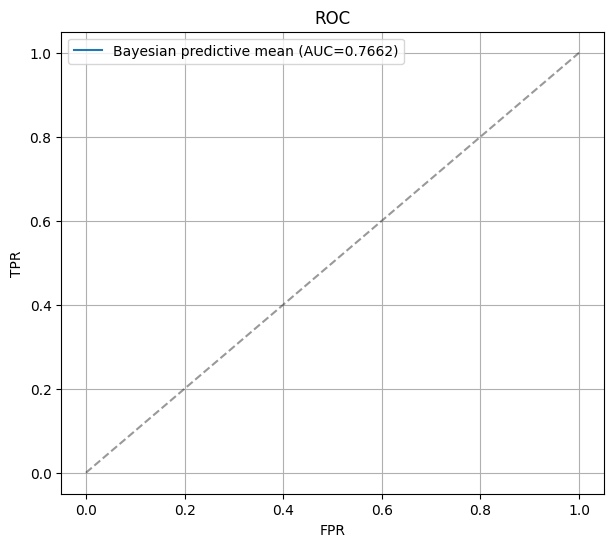

In [8]:
# ROC curve
fpr_b, tpr_b, _ = roc_curve(y_test, posterior_mean_proba, pos_label="s")

plt.figure(figsize=(7, 6))
plt.plot(fpr_b, tpr_b, label=f"Bayesian predictive mean (AUC={auc_bayes:.4f})")
plt.plot([0, 1], [0, 1], "k--", alpha=0.4)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()
plt.grid(True)

In [9]:
ams_bayes = ams_score(y_test, y_pred_bayes, weights_test)
print(f"Bayesian Logistic Regression AMS: {ams_bayes:.4f}")

Bayesian Logistic Regression AMS: 0.7539
